In [1]:
%matplotlib inline

In [2]:
import lsst.sims.skybrightness as sb
import lsst.sims.photUtils.Bandpass as Bandpass
import os
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.selfcal.analysis import healplots
from lsst.sims.skybrightness.utils import robustRMS, ut2Mjd, mjd2ut
from lsst.sims.utils import _altAzPaFromRaDec, haversine, calcLmstLast, _raDecFromAltAz
from lsst.sims.maf.utils.telescopeInfo import TelescopeInfo

Start up a SkyModel object, this reads in the template spectra from ESO.

In [3]:
sm = sb.SkyModel(observatory='LSST', lowerAtm=True, upperAtm=True, airglow=True, scatteredStar=True, mergedSpec=True)
sm.mergedSpec = False

Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.


Set the RA/Dec points and the MJD.  

In [4]:
sm.setRaDecMjd(np.array([36.]),np.array([-68.]),49353.177645, degrees=True)

In [5]:
sm.computeSpec()

/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/pixelfunc.py:1045: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if phi == None:


(1e-17, 1e-14)

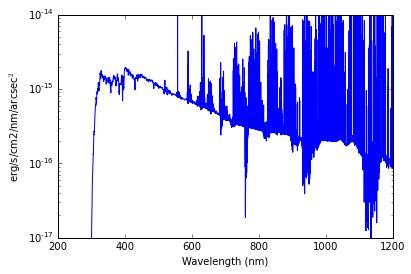

In [6]:
plt.semilogy(sm.wave, sm.spec[0])
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.xlim([200,1200])
plt.ylim([1e-17,1e-14])

Read in the Canon filter throughputs and compute mags from the spectra

In [7]:
canonDict = {}
canonFiles = {'R':'red_canon.csv','G':'green_canon.csv','B':'blue_canon.csv'}

path = os.path.join(os.environ.get('SIMS_SKYBRIGHTNESS_DATA_DIR'), 'Canon')
for key in canonFiles.keys():
    data = np.loadtxt(os.path.join(path,canonFiles[key]), delimiter=',',
                      dtype=zip(['wave','throughput'],[float,float]))
    band = Bandpass()
    band.setBandpass(data['wave'], data['throughput'])
    canonDict[key]=band


In [8]:
rmags = sm.computeMags(canonDict['R'])
gmags = sm.computeMags(canonDict['G'])
bmags = sm.computeMags(canonDict['B'])


In [9]:
print 'rmag = %f, gmag = %f, bmag = %f'%(rmags,gmags,bmags)

rmag = 19.089128, gmag = 19.041743, bmag = 18.965661


We can also check LSST mags

In [10]:
throughPath = os.getenv('LSST_THROUGHPUTS_BASELINE')
keys = ['u','g','r','i','z','y']
filters = {}
for filtername in keys:
    bp = np.loadtxt(os.path.join(throughPath, 'filter_'+filtername+'.dat'),
                    dtype=zip(['wave','trans'],[float]*2 ))
    tempB = Bandpass()
    tempB.setBandpass(bp['wave'],bp['trans'])
    filters[filtername] = tempB
for key in keys:
    print key, sm.computeMags(filters[key])[0]


u 19.5445039895
g 18.9926589327
r 19.1025344179
i 19.115958583
z 18.6541803825
y 17.5996991848


In [11]:
nside = 32

In [12]:
hpmap = np.zeros(hp.nside2npix(nside))

In [13]:
lat, ra = hp.pix2ang(nside, np.arange(hpmap.size))

In [14]:
dec = np.pi/2-lat

In [15]:
sm.setRaDecMjd(ra,dec,49353.177645, degrees=False)

In [16]:
sm.computeSpec()

In [17]:
rmags = sm.computeMags(canonDict['R'])

In [18]:
rmags[np.where(rmags < 0)] = hp.UNSEEN #Mask out pixels where there was no flux

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


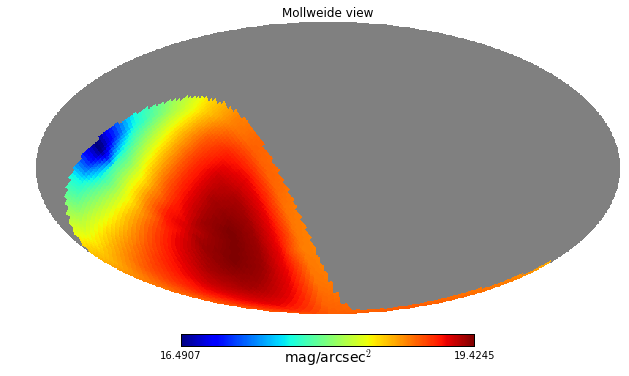

In [19]:
hp.mollview(rmags, unit='mag/arcsec$^2$')

Looks like there's a little issue interpolating at the highest airmass, but it's not too bad.

We can also turn various sky components on/off to see what's dominating. 

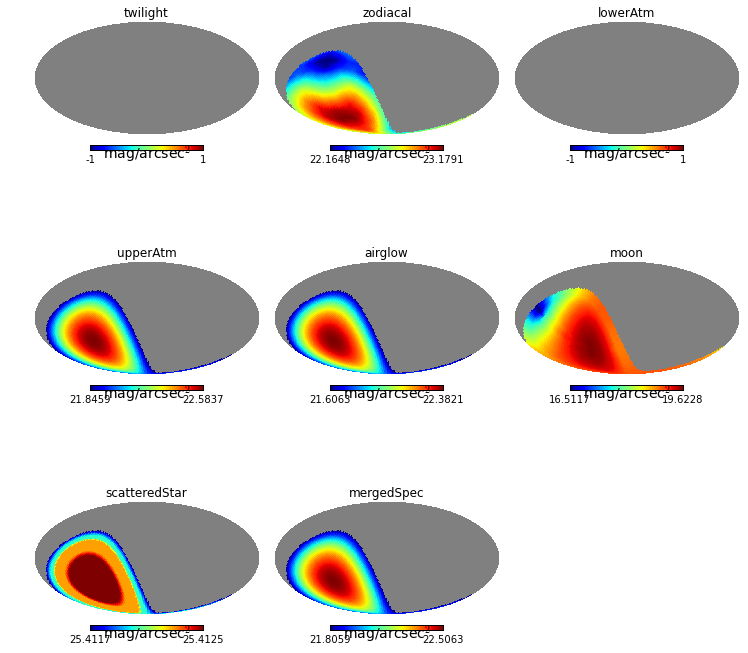

In [20]:
plt.figure(figsize=(10,10))
comps = ['twilight', 'zodiacal', 'lowerAtm', 'upperAtm', 'airglow', 'moon', 'scatteredStar', 'mergedSpec']
for i,comp in enumerate(comps):
    for comp2 in comps:
        setattr(sm, comp2, False)
    setattr(sm, comp, True)
    sm.computeSpec()
    mags = sm.computeMags(canonDict['R'])
    mags[np.where(mags < 0)] = hp.UNSEEN
    hp.mollview(mags, unit='mag/arcsec$^2$', title=comp, sub=(3,3,i+1))
# Turn all the comps back on
for comp in comps:
    setattr(sm, comp, True)
sm.mergedSpec = False

The sky model saves some useful variables on the state of the sky:

In [21]:
print 'sun altitude=%.2f'%np.degrees(sm.sunAlt)

sun altitude=-36.23


In [22]:
print 'moon altitude=%.2f'%np.degrees(sm.moonAlt)

moon altitude=28.34


In [23]:
print 'moon illumination fraction = %.2f'%sm.moonPhase

moon illumination fraction = 88.09


Now we can load up a snapshot from the all-sky camera and calculate a model for it

In [24]:
band = 'R' # Try out the Canon R filter

In [25]:
skydata, mjd = sb.allSkyDB(2133 , filt=band)#2744

In [26]:
airmass = 1./np.cos(np.radians(90.-skydata['alt']))

In [27]:
skydata = skydata[np.where(airmass < 2.1)]

In [28]:
telescope = TelescopeInfo('LSST')
alt,az,pa =  _altAzPaFromRaDec(np.radians(skydata['ra']), np.radians(skydata['dec']),
                        telescope.lon, telescope.lat, mjd)
skyhp = healplots.healbin(az,alt, skydata['sky'], nside=16)

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
sm.setRaDecMjd(np.radians(skydata['ra']), np.radians(skydata['dec']), mjd, degrees=False)
sm.computeSpec()
mags = sm.computeMags(canonDict[band])

In [30]:
good = np.where(mags > 0)

modelhp = healplots.healbin(az[good], alt[good], mags[good], nside=16)
zp = mags[good] - skydata['sky'][good]
resids = mags[good]-skydata['sky'][good]-np.median(zp)


residhp = healplots.healbin(az[good], alt[good],
                            resids, nside=16, reduceFunc=np.mean)


/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/pixelfunc.py:252: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/ma/core.py:2245: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/projaxes.py:996: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/projaxes.py:997: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


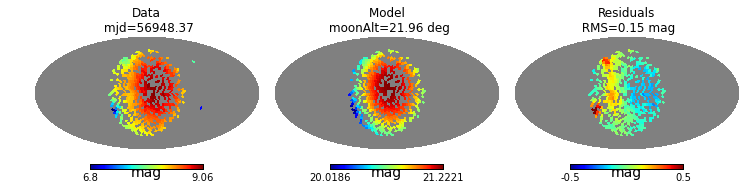

In [31]:
plt.figure(figsize=(10,4))
hp.mollview(skyhp, title='Data\n mjd=%.2f' % mjd, unit='mag', sub=(1,3,1), rot=(0,90))
hp.mollview(modelhp, title='Model \n moonAlt=%.2f deg' % (np.degrees(sm.moonAlt)), unit='mag', sub=(1,3,2), rot=(0,90))
hp.mollview(residhp,  max=0.5, min=-0.5, title='Residuals\n RMS=%.2f mag' % robustRMS(resids), unit='mag', sub=(1,3,3), rot=(0,90))

In [32]:
print 'Robust-RMS of the residuals = %f mag' % robustRMS(resids)

Robust-RMS of the residuals = 0.153518 mag


Residuals dominated by the zodiacal light mis-match at high airmass in the West.  If we go a little later they drop down a lot

In [33]:
skydata, mjd = sb.allSkyDB(2844 , filt=band)
airmass = 1./np.cos(np.radians(90.-skydata['alt']))
skydata = skydata[np.where(airmass < 2.1)]
alt,az,pa =  _altAzPaFromRaDec(np.radians(skydata['ra']), np.radians(skydata['dec']),
                        telescope.lon, telescope.lat, mjd)
skyhp = healplots.healbin(az, alt, skydata['sky'], nside=16)

In [34]:
sm.setRaDecMjd(np.radians(skydata['ra']), np.radians(skydata['dec']), mjd, degrees=False)
sm.computeSpec()
mags = sm.computeMags(canonDict[band])

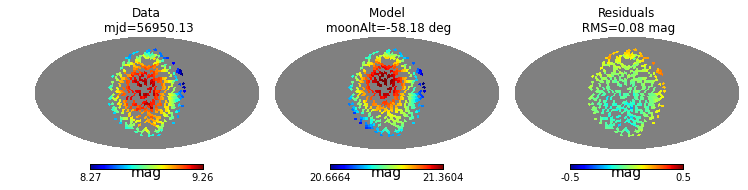

In [35]:
good = np.where(mags > 0)
modelhp = healplots.healbin(az[good], alt[good], mags[good], nside=16)
zp = mags[good] - skydata['sky'][good]
resids = mags[good]-skydata['sky'][good]-np.median(zp)
residhp = healplots.healbin(az[good],alt[good],
                            resids, nside=16, reduceFunc=np.mean)
plt.figure(figsize=(10,4))
hp.mollview(skyhp, title='Data\n mjd=%.2f' % mjd, unit='mag', sub=(1,3,1), rot=(0,90))
hp.mollview(modelhp, title='Model \n moonAlt=%.2f deg' % (np.degrees(sm.moonAlt)), unit='mag', sub=(1,3,2), rot=(0,90))
hp.mollview(residhp,  max=0.5, min=-0.5, title='Residuals\n RMS=%.2f mag' % robustRMS(resids), unit='mag', sub=(1,3,3), rot=(0,90))

In [36]:
print 'Robust-RMS of the residuals = %f mag' % robustRMS(resids)

Robust-RMS of the residuals = 0.082800 mag


In [37]:
# XXX--let's check that the twilight looks reasonable (like the right part of the sky is bright), and the moon too
#skydata, mjd = sb.allSkyDB(1707 , filt=band)
skydata, mjd = sb.allSkyDB(1677 , filt=band)
airmass = 1./np.cos(np.radians(90.-skydata['alt']))
skydata = skydata[np.where(airmass < 2.1)]
alt,az,pa =  _altAzPaFromRaDec(np.radians(skydata['ra']), np.radians(skydata['dec']),
                        telescope.lon, telescope.lat, mjd)
skyhp = healplots.healbin(az, alt, skydata['sky'], nside=16)

sm.setRaDecMjd(np.radians(skydata['ra']), np.radians(skydata['dec']), mjd, degrees=False)
sm.computeSpec()
mags = sm.computeMags(canonDict[band])
print 'Sun Altitude = ', sm.sunAlt
print 'Moon Altitude ', sm.moonAlt

Sun Altitude =  -12:48:23.0
Moon Altitude  -70:11:37.0


Robust-RMS of the residuals = 0.160355 mag
frame zp = 11.98 mag


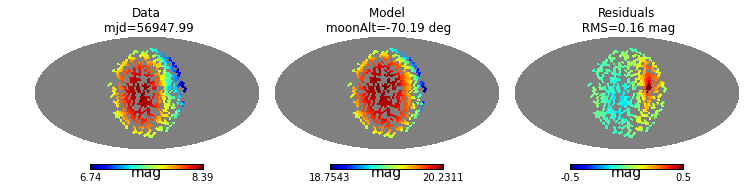

In [38]:
good = np.where(mags > 0)
modelhp = healplots.healbin(az[good], alt[good], mags[good], nside=16)
zp = mags[good] - skydata['sky'][good]
resids = mags[good]-skydata['sky'][good]-np.median(zp)
residhp = healplots.healbin(az[good],alt[good],
                            resids, nside=16, reduceFunc=np.mean)
plt.figure(figsize=(10,4))
hp.mollview(skyhp, title='Data\n mjd=%.2f' % mjd, unit='mag', sub=(1,3,1), rot=(0,90))
hp.mollview(modelhp, title='Model \n moonAlt=%.2f deg' % (np.degrees(sm.moonAlt)), unit='mag', sub=(1,3,2), rot=(0,90))
hp.mollview(residhp,  max=0.5, min=-0.5, title='Residuals\n RMS=%.2f mag' % robustRMS(resids), unit='mag', sub=(1,3,3), rot=(0,90))
print 'Robust-RMS of the residuals = %f mag' % robustRMS(resids)
print 'frame zp = %.2f mag' % np.median(zp)

Conclusions
============

* Have scraped the ESO model and can interpolate values
* Can get spectra and mags of sky after twilight
* Dark sky values match well values in the overview paper
* Qualitative match for sky with moon and/or zodiacal light

Next steps
* Need better unit test coverage of the code
* Put in background component from light scattered off telescope

Compare to solar scattering
============
Figure 5 in:
http://xxx.lanl.gov/pdf/1510.07574.pdf
shows a nice plot of the differential sky brightness.  Let's compare to the moon

In [39]:
sm = sb.SkyModel(observatory='LSST', mags=True)
mjd = 49353.177645
sm.setRaDecMjd(ra,dec,mjd)
sm.computeSpec()
mag = sm.computeMags()
lmst, last = calcLmstLast(mjd,telescope.lon)

/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/skyModel.py:279: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(self.spec)+np.log10(3631.)


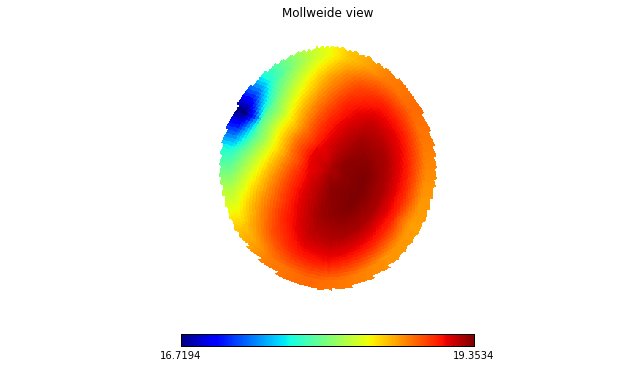

In [40]:
hp.mollview(mag[:,1], rot=(lmst*180./12, np.degrees(telescope.lat)))

In [41]:
moonRA, moonDec =  _raDecFromAltAz(sm.moonAlt, sm.moonAz, telescope.lon, telescope.lat, mjd)

In [42]:
alt, az, pa = _altAzPaFromRaDec(ra,dec, telescope.lon, telescope.lat, mjd)
angDist2Moon = np.degrees(haversine(az,alt, sm.moonAz,sm.moonAlt))
ang2 = np.degrees(haversine(ra,dec, moonRA,moonDec))
alt = np.degrees(alt)

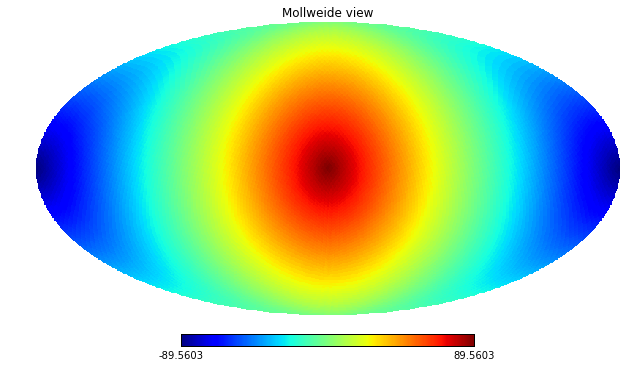

In [43]:
hp.mollview(alt, rot=(lmst*180./12, np.degrees(telescope.lat)))

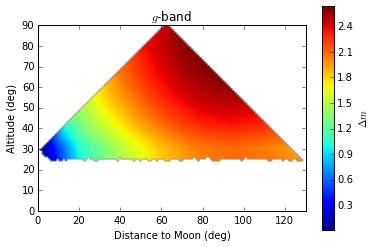

In [46]:
from scipy.interpolate import griddata

mags = mag[:,1]-mag[:,1].min()

extent = (0,130, 0,90)
xs,ys = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]]
resampled = griddata((angDist2Moon, alt), mags, (xs, ys))
blah=plt.imshow(resampled.T, extent=extent, origin='lower')
#blah = plt.hexbin(angDist2Moon, alt, mags)
cb = plt.colorbar(blah)
plt.xlabel('Distance to Moon (deg)')
plt.ylabel('Altitude (deg)')
plt.title('$g$-band')
cb.set_label('$\Delta m$')